<a href="https://colab.research.google.com/github/ZyadSamy96/Head-Pose-Estimation/blob/main/Head_Pose_Estimation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

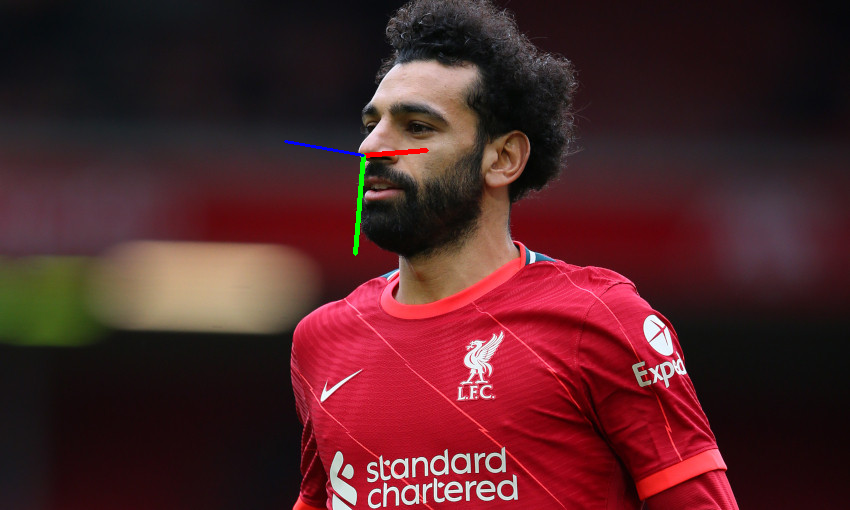

Head Pose Estimation By Zyad Samy

In [6]:
#Installing Mediapipe

!pip -q install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 18.8 MB/s eta 0:00:00


In [7]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from sklearn.model_selection import cross_val_score,GridSearchCV
from math import cos, sin
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import joblib


In [8]:
if os.path.isfile('/drive/AFLW2000-3D.zip') == False:
  !gdown -q 1Zuc9jr0IZ02khqeZkvShevceeDImbAHj
  !unzip -q /content/drive/MyDrive/AFLW2000-3D.zip


Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1Zuc9jr0IZ02khqeZkvShevceeDImbAHj 



In [9]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [10]:
# X_points, Y_points, labels and detected files which are the images thar mp was able to detect the face  
X_points = []
Y_points = []
labels = []
detected_files = []

# extracting the file names (2000 name)
file_names = sorted([Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")])

# detecting faces and extracting the points
faceModule = mp.solutions.face_mesh
# looping over the file names to load the images and their corresponding mat file
for filename in file_names:
  with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+filename+'.jpg')
    # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
          # appending the file names where have been detected.
          detected_files.append(filename)
          # detecting the face
          face = results.multi_face_landmarks[0]
          # initializing two lists to store the points for the image.
          X = []
          Y = []
          # looping over the 468 points of x and y
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image.
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # X_features
              X.append(relative_x)
              # Y_features
              Y.append(relative_y)

          # converting the lists to numpy arrays
          X = np.array(X)
          Y = np.array(Y)
          X_center=(X-X[1])
          Y_center=(Y-Y[1])
          distance = np.linalg.norm(np.array((X[10],Y[10])) - np.array((X[152],Y[152])))
          X_new = X_center/distance
          Y_new = Y_center/distance


          # appending the points of the images in the list of all image points
          X_points.append(X_new)
          Y_points.append(Y_new)

          # loading the mat file to extract the labels (pitch,yaw,roll)
          mat_file = sio.loadmat('/content/AFLW2000/'+filename+'.mat')
          # extracting the labels 3 angels
          pose_para = mat_file["Pose_Para"][0][:3]
          # appending the 3 angels to labels list
          labels.append(pose_para)

X_points = np.array(X_points)
Y_points = np.array(Y_points)
labels = np.array(labels)

# the first label (pitch)
pitch_label = labels[:,0]
# the first label (yaw)
yaw_label = labels[:,1]
# the first label (roll)
roll_label = labels[:,2]
print(X_points.shape)
print(Y_points.shape)
print(labels.shape)
     

(1853, 468)
(1853, 468)
(1853, 3)


In [11]:
features = np.hstack([X_points,Y_points])
print(features.shape)
     

(1853, 936)


In [12]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val,file_train,file_test = train_test_split(features,labels,detected_files,test_size = 0.2,random_state = 20)
y_train_pitch = y_train[:,0]
y_train_yaw = y_train[:,1]
y_train_roll = y_train[:,2]
y_val_pitch = y_val[:,0]
y_val_yaw = y_val[:,1]
y_val_roll = y_val[:,2]

In [ ]:

xg_parameters = {'n_estimators': np.arange(7,15,2),'max_depth': np.arange(1,10,2),'learning_rate': np.arange(0.5,1,0.2)}
# grid search pitch
xg = XGBRegressor(random_state=0,verbosity = 0)
xg_gs_pitch = GridSearchCV(estimator = xg,param_grid = xg_parameters)
xg_gs_pitch.fit(X_train, y_train_pitch)
xg_winner_pitch = xg_gs_pitch.best_estimator_
print("Pitch Winner Model: ",xg_winner_pitch)
print("Train Error: ",mean_absolute_error(xg_winner_pitch.predict(X_train),y_train_pitch))
print("Validation Error: ",mean_absolute_error(xg_winner_pitch.predict(X_val),y_val_pitch))

Pitch Winner Model:  XGBRegressor(learning_rate=0.5, max_depth=1, n_estimators=9, verbosity=0)
Train Error:  0.14614102913929222
Validation Error:  0.18747375380107253


In [ ]:
xg = XGBRegressor(random_state=0,verbosity = 0)
xg_gs_yaw = GridSearchCV(estimator = xg,param_grid = xg_parameters)
xg_gs_yaw.fit(X_train, y_train_yaw)
xg_winner_yaw = xg_gs_yaw.best_estimator_
print("Yaw Winner Model: ",xg_winner_yaw)
print("Train Error: ",mean_absolute_error(xg_winner_yaw.predict(X_train),y_train_yaw))
print("Validation Error: ",mean_absolute_error(xg_winner_yaw.predict(X_val),y_val_yaw))

Yaw Winner Model:  XGBRegressor(learning_rate=0.5, n_estimators=11, verbosity=0)
Train Error:  0.06947699208493847
Validation Error:  0.10572845735361253


In [ ]:
xg = XGBRegressor(random_state=0,verbosity = 0)
xg_gs_roll = GridSearchCV(estimator = xg,param_grid = xg_parameters)
xg_gs_roll.fit(X_train, y_train_roll)
xg_winner_roll = xg_gs_roll.best_estimator_
print("Yaw Winner Model: ",xg_winner_roll)
print("Train Error: ",mean_absolute_error(xg_winner_roll.predict(X_train),y_train_roll))
print("Validation Error: ",mean_absolute_error(xg_winner_roll.predict(X_val),y_val_roll))
     

Yaw Winner Model:  XGBRegressor(learning_rate=0.5, max_depth=1, n_estimators=11, verbosity=0)
Train Error:  0.11162943034591843
Validation Error:  0.19416940674863378


In [ ]:
svr_parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'C':[0.01,0.1,1,10,100]}
# grid search pitch
svr = SVR()
svr_gs_pitch = GridSearchCV(estimator = svr,param_grid = svr_parameters)
svr_gs_pitch.fit(X_train, y_train_pitch)
svr_winner_pitch = svr_gs_pitch.best_estimator_
print("Pitch Winner Model: ",svr_winner_pitch)
print("Train Error: ",mean_absolute_error(svr_winner_pitch.predict(X_train),y_train_pitch))
print("Validation Error: ",mean_absolute_error(svr_winner_pitch.predict(X_val),y_val_pitch))

Pitch Winner Model:  SVR(C=100, kernel='poly')
Train Error:  0.08916061639184222
Validation Error:  0.09865072722791875


In [ ]:
# grid search yaw

svr = SVR()
svr_gs_yaw = GridSearchCV(estimator = svr,param_grid = svr_parameters)
svr_gs_yaw.fit(X_train, y_train_yaw)
svr_winner_yaw = svr_gs_yaw.best_estimator_
print("Yaw Winner Model: ",svr_winner_yaw)
print("Train Error: ",mean_absolute_error(svr_winner_yaw.predict(X_train),y_train_yaw))
print("Validation Error: ",mean_absolute_error(svr_winner_yaw.predict(X_val),y_val_yaw))

Yaw Winner Model:  SVR(C=10)
Train Error:  0.06962008777326038
Validation Error:  0.0733877128371739


In [ ]:
# grid search roll
svr = SVR()
svr_gs_roll = GridSearchCV(estimator = svr,param_grid = svr_parameters)
svr_gs_roll.fit(X_train, y_train_roll)
svr_winner_roll = svr_gs_roll.best_estimator_
print("Yaw Winner Model: ",svr_winner_roll)
print("Train Error: ",mean_absolute_error(svr_winner_roll.predict(X_train),y_train_roll))
print("Validation Error: ",mean_absolute_error(svr_winner_roll.predict(X_val),y_val_roll))
     

Yaw Winner Model:  SVR(C=10)
Train Error:  0.07651209845977225
Validation Error:  0.07979128805442443


In [ ]:
print(svr_gs_roll.score(X_val, y_val_roll))
print(svr_gs_pitch.score(X_val, y_val_pitch))
print(svr_gs_yaw.score(X_val, y_val_yaw))

0.6366330276920584
0.4872536532678773
0.9453845304238833


In [13]:
p_svr=SVR(C=100, kernel='poly')
y_svr=SVR(C=10)
r_svr=SVR(C=10)

In [14]:
p_svr.fit(X_train, y_train_pitch)
y_svr.fit(X_train, y_train_yaw)
r_svr.fit(X_train, y_train_roll)

SVR(C=10)

In [17]:
print(r_svr.score(X_val, y_val_roll))
print(p_svr.score(X_val, y_val_pitch))
print(y_svr.score(X_val, y_val_yaw))

0.6366330276920584
0.4872536532678773
0.9453845304238833


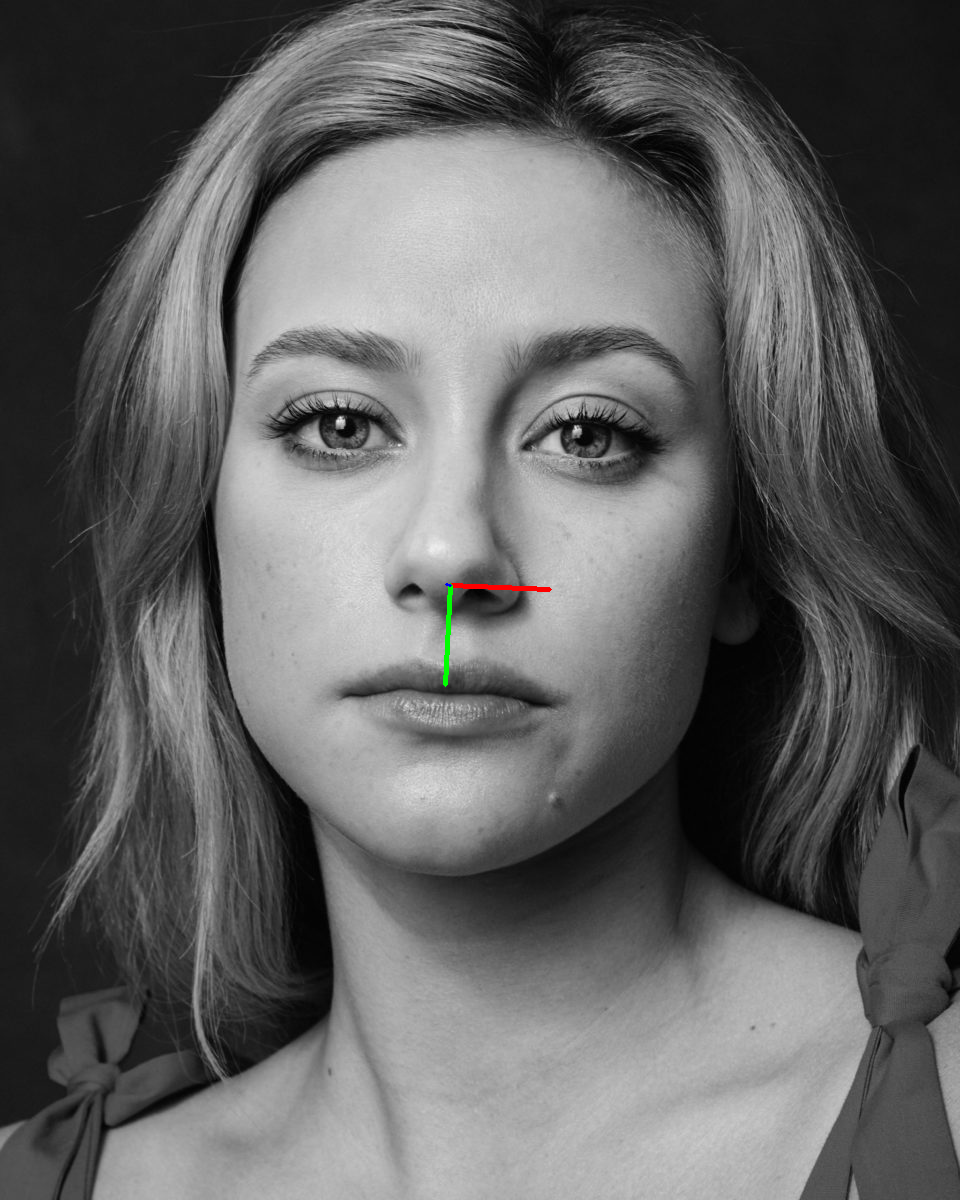

In [15]:
image_name='aaaa'
faceModule = mp.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  frame = cv2.imread('/content/drive/MyDrive/' + image_name + '.jpg')
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        X = []
        Y = []
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            X.append(relative_x)
            Y.append(relative_y)

        X = np.array(X)
        Y = np.array(Y)

        X_center=(X-X[1])
        Y_center=(Y-Y[1])
        distance = np.linalg.norm(np.array((X[10],Y[10])) - np.array((X[152],Y[152])))
        X_new = X_center/distance
        Y_new = Y_center/distance


        # concatinating the x and y points to predict the labels (pitch,yaw,roll)
        points = np.hstack([X_new,Y_new]).reshape(1,-1)
        # predicting the 3 angels to draw the axis on the image
  
        pred_pitch = p_svr.predict(points)
        pred_yaw = y_svr.predict(points)
        pred_roll = r_svr.predict(points)
        cv2_imshow(draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[1],Y[1]))

In [51]:
# Create a VideoCapture object and read from input file
def Head_Pose_Video_with_Smoothing(file_path,pitch_model,yaw_model,roll_model,smoothing = False,smoothing_factor=20):
  cur_size=0
  cap = cv2.VideoCapture(file_path)
  width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # Check if camera opened successfully
  if (cap.isOpened()== False): 
      print("Error opening video file")

  
  pitch_L =[]
  yaw_L = []
  roll_L = []

  # initializing a list to store the frames   
  frames_array = []
  # Read until video is completed
  while(cap.isOpened()):   
    # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == True:
        with faceModule.FaceMesh(static_image_mode=True) as face:
          # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
          results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
          if results.multi_face_landmarks != None:
            for face in results.multi_face_landmarks:
                # initializing X and Y lists to store the spacial coordinates of the points
                X = []
                Y = []
                # looping over the landmarks to extract x and y
                for j,landmark in enumerate(face.landmark):
                    x = landmark.x
                    y = landmark.y
                    # retrieve the true values of x and y
                    shape = frame.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    X.append(relative_x)
                    Y.append(relative_y)

                X = np.array(X)
                Y = np.array(Y)
                # centering the data arround the point 99
                X_center = X - X[1]
                Y_center = Y - Y[1]
                distance = np.linalg.norm(np.array((X[152],Y[152])) - np.array((X[10],Y[10])))
                X_norm = X_center/distance
                Y_norm = Y_center/distance
                X_norm = X_norm
                Y_norm = Y_norm
                points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
                # predicting the 3 angels to draw the axis on the image
                pred_pitch = p_svr.predict(points)
                pred_yaw = y_svr.predict(points)
                pred_roll = r_svr.predict(points)
                
                if smoothing  == True:
                  if cur_size < smoothing_factor:
                  
                    pitch_L.append(pred_pitch)
                    yaw_L.append(pred_yaw)
                    roll_L.append(pred_roll)
                    cur_size+=1
                  
                  else: 
                    if len(pitch_L) >0:
                      del pitch_L[0]
                      del yaw_L[0]
                      del roll_L[0]
                      cur_size-=1

                      if cur_size < smoothing_factor:

                        pitch_L.append(pred_pitch)
                        yaw_L.append(pred_yaw)
                        roll_L.append(pred_roll)
                        cur_size+=1



                  pitch = sum(pitch_L)/len(pitch_L)
                  yaw = sum(yaw_L)/len(yaw_L)
                  roll = sum(roll_L)/len(roll_L)
                  draw_axis(frame,pitch,yaw,roll,X[1],Y[1],0.3*distance)

                 



                else : draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[1],Y[1],0.3*distance)

                # appending the result frame to the img_array list
                frames_array.append(frame)
      # Break the loop
      else:  break

  cap.release()  
  # Closes all the frames
  cv2.destroyAllWindows()
  print("Number of Detected Frames = ",len(frames_array))
  # converting the frames to video
  out = cv2.VideoWriter('out.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 30, (width,height))
  for i in range(len(frames_array)):
    out.write(frames_array[i])
  out.release()
     


In [54]:
path='/content/drive/MyDrive/WhatsApp Video 2023-02-21 at 8.14.01 PM.mp4'
Head_Pose_Video_with_Smoothing(path,p_svr,y_svr,r_svr,smoothing = True,smoothing_factor=2)

from google.colab import files
files.download('/content/out.mp4') 

Number of Detected Frames =  429


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# Create a VideoCapture object and read from input file
def Head_Pose_Video(file_path,pitch_model,yaw_model,roll_model,smoothing = False):

  cap = cv2.VideoCapture(file_path)
  width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # Check if camera opened successfully
  if (cap.isOpened()== False): 
      print("Error opening video file")

  
  pitch_L =[]
  yaw_L = []
  roll_L = []

  # initializing a list to store the frames   
  frames_array = []
  # Read until video is completed
  while(cap.isOpened()):   
    # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == True:
        with faceModule.FaceMesh(static_image_mode=True) as face:
          # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
          results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
          if results.multi_face_landmarks != None:
            for face in results.multi_face_landmarks:
                # initializing X and Y lists to store the spacial coordinates of the points
                X = []
                Y = []
                # looping over the landmarks to extract x and y
                for j,landmark in enumerate(face.landmark):
                    x = landmark.x
                    y = landmark.y
                    # retrieve the true values of x and y
                    shape = frame.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    X.append(relative_x)
                    Y.append(relative_y)

                X = np.array(X)
                Y = np.array(Y)
                # centering the data arround the point 99
                X_center = X - X[1]
                Y_center = Y - Y[1]
                distance = np.linalg.norm(np.array((X[152],Y[152])) - np.array((X[10],Y[10])))
                X_norm = X_center/distance
                Y_norm = Y_center/distance
                X_norm = X_norm
                Y_norm = Y_norm
                points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
                # predicting the 3 angels to draw the axis on the image
                pred_pitch = p_svr.predict(points)
                pred_yaw = y_svr.predict(points)
                pred_roll = r_svr.predict(points)
                
                if smoothing  == True:
                  
                  pitch_L.append(pred_pitch)
                  yaw_L.append(pred_yaw)
                  roll_L.append(pred_roll)
                 

                  draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[1],Y[1],0.3*distance)
                # appending the result frame to the img_array list
                frames_array.append(frame)
      # Break the loop
      else:  break

  cap.release()  
  # Closes all the frames
  cv2.destroyAllWindows()
  print("Number of Detected Frames = ",len(frames_array))
  # converting the frames to video
  out = cv2.VideoWriter('out.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 30, (width,height))
  for i in range(len(frames_array)):
    out.write(frames_array[i])
  out.release()
     


In [17]:
path='/content/drive/MyDrive/WhatsApp Video 2023-02-26 at 7.03.47 PM.mp4'
Head_Pose_Video(path,p_svr,y_svr,r_svr,smoothing = True)


Number of Detected Frames =  562


In [18]:
from google.colab import files
files.download('/content/out.mp4') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:

zoz_model_roll = "zoz_model_roll.pkl"
joblib.dump(r_svr, zoz_model_roll)

zoz_model_pitch = "zoz_model_pitch.pkl"
joblib.dump(p_svr, zoz_model_pitch)

zoz_model_yaw = "zoz_model_yaw.pkl"
joblib.dump(y_svr, zoz_model_yaw)



['zoz_model_yaw.pkl']

In [24]:
zoz_svm_model_roll  = joblib.load('/content/zoz_model_roll.pkl')
zoz_svm_model_pitch = joblib.load('/content/zoz_model_pitch.pkl')
zoz_svm_model_yaw = joblib.load('/content/zoz_model_yaw.pkl')

In [ ]:
print(zoz_svm_model_roll)
print(zoz_svm_model_pitch)
print(zoz_svm_model_yaw)

SVR(C=10)
SVR(C=100, kernel='poly')
SVR(C=10)
